In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/elomia

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/elomia


In [2]:
import tensorflow as tf 

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.124.88.26:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.124.88.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.88.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


In [3]:
!pip install tensorflow-datasets==4.1.0
import tensorflow_datasets as tfds

# EMP DATASET

In [4]:
import pandas as pd

pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

emd_df = pd.read_csv("API/ParlAI_ex/emp_data_train.csv", on_bad_lines='skip')
emd_df['utterance'] = emd_df['utterance'].str.lower()
emd_df['prompt'] = emd_df['prompt'].str.lower()

emd_df.reset_index(inplace=True)

In [5]:
emd_df['utterance'].head()

0    i remember going to see the fireworks with my best friend. it was the first time we ever spent t...
1                                  was this a friend you were in love with_comma_ or just a best friend?
2                                                                    this was a best friend. i miss her.
3                                                                                    where has she gone?
4                                                                                     we no longer talk.
Name: utterance, dtype: object

# DAILYDIAL DATASET

In [6]:
import os 

diag_path = "API/ParlAI_ex/daily_dialog/train/dialogues_train.txt"
emo_path = "API/ParlAI_ex/daily_dialog/train/dialogues_emotion_train.txt"

end_phrase_token = "__eou__"

def convert_to_int_list(arr):
    return list(map(lambda x: int(x), arr))

with open(emo_path) as f:
    emos = f.readlines()
    emos = list(map(lambda x: convert_to_int_list(x.split(" ")[:-1]), emos)) # drop last "\n"
    # emos = list(map(lambda x: int(x), emos))
    print(emos)

prompts = []
answers = []

with open(diag_path) as f:
    lines = f.readlines()
    for index, line in enumerate(lines):
        diag_list = line.split(end_phrase_token)[:-1]# drop last "\n"

        if len(diag_list) % 2 != 0:
          diag_list = diag_list[:-1]

        emos_item = emos[index]

        for j, item in enumerate(diag_list): 

            if j%2==0:
                prompts.append(item)
            else:
                answers.append(item)

[[0, 0, 0, 0, 0, 0, 4, 4, 4, 4], [0, 0, 6, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 6, 0, 6, 0], [0, 4, 0, 0, 0, 4, 0, 0, 0, 4], [0, 6, 0, 0, 0, 0, 0], [0, 0, 0, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4], [0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 4, 0, 6, 0], [0, 0, 0, 0, 0], [4, 4, 0, 4, 0, 0, 0, 4], [0, 0, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 0], [0, 0, 0, 0, 0, 6, 0, 0], [0, 0, 0, 0, 0, 4], [0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4], [4, 4], [0, 0], [3, 4, 4], [0, 4, 0, 0, 0, 4], [0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 4, 4, 0, 0, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 6], [0, 0, 0, 0, 0, 4], [0, 0, 4, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0], [4, 4, 4, 4, 4, 4], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4, 4,

# Therapy dataset

In [7]:
import pandas as pd 

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100

# Therapist should be model! user input is prompt and model output is answer is utter (I mean vice versa as before)
dial_df = pd.read_csv("API/ParlAI_ex/therapy_annomi_dataset/dataset.csv")
dial_df.head(100)

,transcript_id,mi_quality,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,main_therapist_behaviour,client_talk_type
0,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,Thanks for filling it out. We give this form to everyone once a year regardless of why they come...,question,NaN
1,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,Sure.,NaN,neutral
2,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,"So, let's see. It looks that you put-- You drink alcohol at least four times a week on average-",therapist_input,NaN
3,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,Mm-hmm.,NaN,neutral
4,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,-and you usually have three to four drinks when you do drink.,therapist_input,NaN
5,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,5,client,00:00:39,Usually three drinks and glasses of wine.,NaN,neutral
6,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,6,therapist,00:00:42,Okay. That's at least 12 drinks a week.,therapist_input,NaN
7,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,7,client,00:00:46,Something like that.,NaN,neutral
8,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,8,therapist,00:00:47,"Okay. Just so you know, my role, um, when we talk about alcohol use, is just to share informatio...",therapist_input,NaN
9,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,9,client,00:01:03,Okay.,NaN,neutral


In [8]:
th_prompts = ["Hi, there"] # added to correct order to make model is therapist role because in data therapist is always first
th_utters = []
prev_value = ""
for df_item in dial_df["transcript_id"].unique():
    slice_item = dial_df[dial_df["transcript_id"] == df_item]

    if len(slice_item) % 2 != 0:
        slice_item = slice_item[:-1]

    for row in slice_item.iterrows() :
        interlocutor = row[1]["interlocutor"]
        
        is_prev_value = interlocutor == prev_value
        prev_value = interlocutor

        if interlocutor == "therapist":

          if is_prev_value:
            th_utters[-1] += row[1]["utterance_text"]
          else:
            th_utters.append(row[1]["utterance_text"])

        else:

          if is_prev_value:
            th_prompts[-1] += row[1]["utterance_text"]
          else:
            th_prompts.append(row[1]["utterance_text"])


        # print(row[1]["interlocutor"])
    #     print(row[1]["utterance_text"])
    #     print("\n\n")

    # print("end")

        

In [9]:
print(len(prompts))
print(len(answers))
print(len(emd_df['prompt'].tolist()))
print(len(emd_df['utterance'].tolist()))

41638
41638
76668
76668


In [10]:
import random 

prompts = prompts + emd_df['prompt'].tolist()
utterances = answers + emd_df['utterance'].tolist()

c = list(zip(prompts, utterances))

random.shuffle(c)

prompts, utterances = zip(*c)

# Maximum sentence length
MAX_LENGTH = 512

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 #* strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40

In [11]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    prompts + utterances, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]



#### !!!!
VOCAB_SIZE = tokenizer.vocab_size + 2 #8185 # 

In [12]:
print(VOCAB_SIZE)

8185


In [13]:

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(prompts, utterances)

In [14]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
questions[0]

array([8183,  695, 1189,   20,   42,    2, 1101,    7,    1,  248,    2,
        112,  449,    4, 2930,  118, 1133,   27,    6, 1000,    7, 8032,
       7966,   31, 3394,  190,  965,    4,  983,  172, 2670,  298,    8,
         49,  355, 7966,   21,   32,  196,    2,   41,   12,   15,  497,
         16,    3,  174,  127,    7,  288,   26,  284,  195, 8184,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# TRANSFORMER

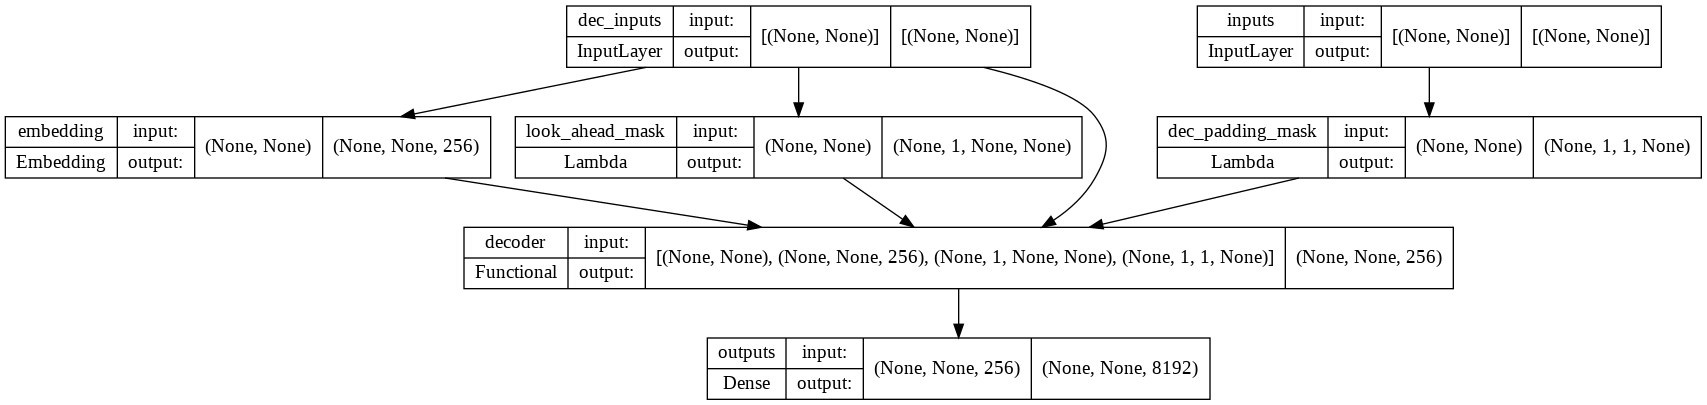

In [16]:
from transformer.components.transformer import transformer
import tensorflow as tf
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=6,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.3,
    is_encoder=False,
    name="sample_transformer")

tf.keras.utils.plot_model(sample_transformer, 
                          to_file='transformer.png',
                          show_shapes=True)

In [17]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps
    
  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

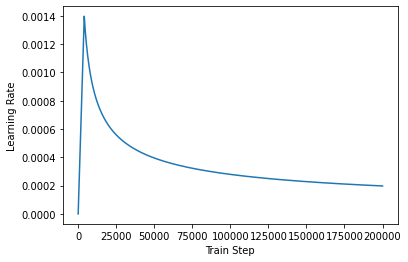

In [19]:
import matplotlib.pyplot as plt
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [50]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope

NUM_LAYERS = 8
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1


with strategy.scope():
    model = transformer(vocab_size=VOCAB_SIZE,
                        num_layers=NUM_LAYERS,
                        units=UNITS,
                        d_model=D_MODEL,
                        num_heads=NUM_HEADS,
                        is_encoder=False,
                        dropout=DROPOUT)

    optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                         beta_1=0.9,
                                         beta_2=0.98, 
                                         epsilon=1e-9)

    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                     model=model)
    
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# model = tf.keras.models.load_model(keras_model_path)

# model.load_weights("/content/drive/MyDrive/elomia/API/ParlAI_ex/custom_trans/daily_dial_and_emp/checkpoints/checkpoints")

# model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# model.summary()

In [ ]:
import time
from tqdm import tqdm

exp_path = './API/ParlAI_ex/custom_trans/emp_and_daily_ds_just_decoder'
checkpoint_prefix = os.path.join(exp_path, "ckpt")

def train_step(inputs):
    x, y = inputs
    with tf.GradientTape() as tape:
      predictions = model([x["inputs"], x["dec_inputs"]], training=True)
      loss = loss_function(y["outputs"], predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy.update_state(y["outputs"], predictions)

    return loss 

@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, 
                          per_replica_losses,
                          axis=None)

train_dist_dataset = strategy.experimental_distribute_dataset(dataset)

for epoch in range(10):
    total_loss = 0.0
    num_batches = 0

    ep_start_time = time.time()

    for x in tqdm(train_dist_dataset):
        total_loss += distributed_train_step(x)
        num_batches += 1

    train_loss = total_loss / num_batches

    if epoch % 2 == 0:
        checkpoint.save(checkpoint_prefix)

    template = ("Epoch {}, Loss: {}, Accuracy: {}, time: {}")
    print(template.format(epoch + 1, 
                          train_loss,
                          train_accuracy.result() * 100), 
                          time.time() - ep_start_time)

551it [02:57,  5.49it/s]

In [ ]:
# # problem when encoder is false we pass input len (300 vut 512) but embeddings have dims d_model 512 check mask thing
# # https://www.tensorflow.org/tutorials/distribute/custom_training

# import os
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')

# exp_path = './API/ParlAI_ex/custom_trans/emp_and_daily_ds_just_decoder'

# # tensoboard_callback = TensorBoard(log_dir=exp_path, options = checkpoint_options)

# checkpoint_callback = ModelCheckpoint(os.path.join(exp_path,"checkpoints"),
#                                       monitor='loss', 
#                                       options=checkpoint_options,
#                                       verbose=1,
#                                       mode='min',
#                                       save_weights_only=True,
#                                       save_best_only=True)

# model.fit(dataset,
          
#           callbacks=[checkpoint_callback],
#           epochs=600)

In [ ]:

def evaluate(sentence):
  # sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
output = predict("Do you like cats?")